In [21]:
import random
import pandas as pd
import torch
from d2l import torch as d2l
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
def synthetic_data(w, b, num_examples):  #@save
    """
    生成y=Xw+b+噪声，
    :param w: 数据集矩阵X中每一列特征对应的权重，X有几列特征，其维度就是几
    :param b: 偏置
    :param num_examples: 需要生成的数量，等于数据集矩阵X的行数
    :return: y=Xw+b+噪声
    """
    X = torch.normal(0, 1, (num_examples, len(w)))  # 生成一个随机的num_examples×len(w)的数据矩阵
    y = torch.matmul(X, w) + b  # 计算y=Xw+b
    y += torch.normal(0, 0.01, y.shape)  # y需要加上一个随机噪声
    return X, y.reshape((-1, 1))  # 需要保证y为一个n×1的列向量

In [50]:
synthetic_data(torch.tensor([1., 2]), 3, 2)

(tensor([[ 2.0502, -0.7612],
         [ 2.7861,  0.4638]]),
 tensor([[3.5167],
         [6.7165]]))

In [52]:
true_w, true_b = torch.tensor([2, -3.4]), 4.2  # 定义w与b
features, labels = synthetic_data(true_w, true_b, 1000)

注意，[**`features`中的每一行都包含一个二维数据样本，`labels`中的每一行都包含一维标签值（一个标量）**]。

In [53]:
# 查看生成的随机数据
data_df = pd.concat([pd.DataFrame(features.numpy()), pd.DataFrame(labels.numpy())], axis=1)
data_df.columns = ['features_x_1', 'features_x_2', 'labels']
data_df

,features_x_1,features_x_2,labels
0,0.242345,0.119017,4.294540
1,-1.614622,0.646481,-1.226078
2,-0.517461,-0.212010,3.888116
3,0.294056,-0.062140,5.011658
4,-1.096721,1.614702,-3.471347
...,...,...,...
995,0.276628,0.391437,3.436096
996,-0.567091,-0.582419,5.049109
997,-0.094335,-1.035186,7.544005
998,0.092004,0.692002,2.028725


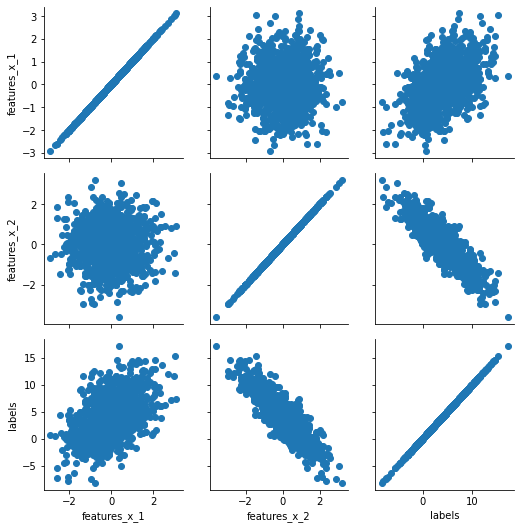

In [22]:
# 可视化生成的随机数据
g = sns.PairGrid(data_df)
g = g.map(plt.scatter)

在下面的代码中，我们[**定义一个`data_iter`函数，
该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为`batch_size`的小批量**]。
每个小批量包含一组特征和标签。

In [54]:
def data_iter(batch_size, X, y):
    """
    从数据集(X, y)中随机抽取batch_size个样本
    :param batch_size: 抽取的样本个数
    :param X: features数据
    :param y: label数据
    :return: yield出每一个样本的features以及对应的label
    """
    num_examples = len(X)  # 获取样本个数
    indices = list(range(num_examples))  # 制造一个样本编号，用于随机取样
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)  # 随机打乱编号
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i: min(i + batch_size, num_examples)])
        yield X[batch_indices], y[batch_indices]


batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-1.6474, -1.1297],
        [-0.1038, -0.0888],
        [-0.0993,  0.3795],
        [-1.1448,  0.7554],
        [-1.0143, -0.6955],
        [ 0.2679,  0.7461],
        [-2.0957,  0.2302],
        [-0.4299,  0.2922],
        [ 0.8904,  0.0925],
        [-0.9260,  2.7237]]) 
 tensor([[ 4.7364],
        [ 4.2806],
        [ 2.7056],
        [-0.6576],
        [ 4.5422],
        [ 2.2149],
        [-0.7838],
        [ 2.3387],
        [ 5.6672],
        [-6.8982]])
tensor([[-1.0675,  0.0875],
        [ 1.9527,  0.4174],
        [-1.4843,  0.5773],
        [-1.1728,  1.0101],
        [-0.9119,  1.3425],
        [-0.2144, -0.4051],
        [-0.7500,  1.5351],
        [-0.9563,  1.3425],
        [ 0.2767, -2.4076],
        [ 0.6287, -0.2465]]) 
 tensor([[ 1.7609],
        [ 6.6726],
        [-0.7236],
        [-1.5969],
        [-2.1717],
        [ 5.1434],
        [-2.5211],
        [-2.2742],
        [12.9448],
        [ 6.3029]])


In [46]:
a = [1, 2, 3]
features[a]

tensor([[-0.5133, -0.5622],
        [-0.5383,  2.1000],
        [ 0.4283, -0.3544]])

In [56]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b


def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2


def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [60]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

lr = 0.03  # 定义学习率
num_epochs = 10  # 定义迭代周期
net = linreg  # 定义迭代方式（模型）
loss = squared_loss  # 定义损失函数

In [61]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.038235
epoch 2, loss 0.000138
epoch 3, loss 0.000050
epoch 4, loss 0.000049
epoch 5, loss 0.000050
epoch 6, loss 0.000049
epoch 7, loss 0.000049
epoch 8, loss 0.000049
epoch 9, loss 0.000049
epoch 10, loss 0.000049


## 借用PyTorch包来实现

In [62]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [64]:
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [71]:
next(iter(data_iter))

[tensor([[-0.0867,  1.2658],
         [ 0.8725,  0.0718],
         [-0.4486,  1.3419],
         [ 0.6208, -1.2087],
         [-1.0970, -0.9565],
         [-0.2436, -0.7075],
         [-2.1569, -0.0392],
         [ 0.9425, -0.1727],
         [ 1.4995, -0.9296],
         [ 1.1002, -0.1147]]),
 tensor([[-0.2681],
         [ 5.7026],
         [-1.2637],
         [ 9.5425],
         [ 5.2667],
         [ 6.1190],
         [ 0.0262],
         [ 6.6831],
         [10.3529],
         [ 6.8002]])]

In [72]:
# nn是神经网络的缩写
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

In [73]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [74]:
loss = nn.MSELoss()

In [ ]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)